# [프로젝트] 머신러닝 모델을 제품으로 만들어보자

# 목차
- 0. 모델 고정해서 사용하기
- 1. Data Centric AI 맛보기
- 2. 하이퍼파라미터 튜닝
- 3. 모델 배포하기 (옵션)
- 4. TFLite 모델 만들기 (옵션)

## 0. 모델 고정해서 사용하기

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Flatten, Dense, Dropout

# Create the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    AveragePooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

## 1. Data Centric AI 맛보기

In [2]:
import keras
from tensorflow.keras.datasets import cifar10

# CIFAR10 데이터셋 로드
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [3]:
from tensorflow.keras.utils import to_categorical

# 수정 전용 원본 백업
y_test_raw = y_test.copy()

# 정규화
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot 인코딩
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [4]:
from sklearn.model_selection import train_test_split

# train / validation 분할
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
print(x_train.shape)

(40000, 32, 32, 3)


In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# class_names (라벨 인덱스와 이름 매핑)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# 수정할 레이블 정보 (image_id: corrected_label_index)
label_corrections = {
    2405: 6,   # cat → frog
    6877: 8,   # airplane → ship
    8058: 7,   # deer → horse
    2532: 1,   # airplane → automobile
    1969: 9,   # automobile → truck
    2804: 5,   # cat → dog
    6792: 9,   # cat → truck
    1227: 5,   # cat → dog
    5191: 5,   # cat → dog
    5690: 4,   # horse → deer
    1718: 8,   # airplane → ship
    2592: 4,   # bird → deer
    4794: 2,   # deer → bird
    165: 2,    # deer → bird
    9227: 9,   # automobile → truck
    5632: 5,   # cat → dog
    6966: 8,   # airplane → ship
    5468: 3    # dog → cat
}

# 수정 내역 저장
corrected_labels = {}

for image_id, new_label in label_corrections.items():
    old_label = int(y_test_raw[image_id][0])  # 원본에서 가져오기
    if old_label != new_label:
        y_test_raw[image_id][0] = new_label  # 원본 업데이트
        corrected_labels[image_id] = (old_label, new_label)

In [7]:
# 출력
print(f"\n총 수정된 이미지 수: {len(corrected_labels)}")
for idx, (before, after) in corrected_labels.items():
    print(f"ID {idx}: {class_names[int(before)]} ➡️ {class_names[int(after)]}")


총 수정된 이미지 수: 18
ID 2405: cat ➡️ frog
ID 6877: airplane ➡️ ship
ID 8058: deer ➡️ horse
ID 2532: airplane ➡️ automobile
ID 1969: automobile ➡️ truck
ID 2804: cat ➡️ dog
ID 6792: cat ➡️ truck
ID 1227: cat ➡️ dog
ID 5191: cat ➡️ dog
ID 5690: horse ➡️ deer
ID 1718: airplane ➡️ ship
ID 2592: bird ➡️ deer
ID 4794: deer ➡️ bird
ID 165: deer ➡️ bird
ID 9227: automobile ➡️ truck
ID 5632: cat ➡️ dog
ID 6966: airplane ➡️ ship
ID 5468: dog ➡️ cat


## 2. 하이퍼파라미터 튜닝

In [8]:
# 라이브러리 설치
!pip install keras-tuner

     |████████████████████████████████| 129 kB 6.7 MB/s            


In [9]:
# 라이브러리 불러오기
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from kerastuner.tuners import Hyperband
from tensorflow.keras.datasets import cifar10

/tmp/ipykernel_145/1674978988.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [10]:
# 모델 생성 함수
def build_model(hp):
    model = Sequential()
    
    # 첫 번째 Conv2D 레이어
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(32, 32, 3)
    ))
    model.add(AveragePooling2D((2, 2)))
    model.add(BatchNormalization())
    
    # 두 번째 Conv2D 레이어
    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(AveragePooling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    
    # Dense 레이어
    model.add(Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=128),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))
    
    # 모델 컴파일
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [11]:
# Hyperband 튜너 생성
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='cifar10_tuning',
    project_name='cifar10_hyperband'
)

# 콜백 설정
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# 튜닝 시작
tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=[stop_early])

Trial 26 Complete [00h 00m 46s]
val_accuracy: 0.6920999884605408

Best val_accuracy So Far: 0.7217000126838684
Total elapsed time: 01h 31m 15s


In [12]:
# 최적의 하이퍼파라미터 출력
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of filters in the first Conv2D layer is {best_hps.get('conv1_filters')},
the optimal number of filters in the second Conv2D layer is {best_hps.get('conv2_filters')},
the optimal number of units in the Dense layer is {best_hps.get('dense_units')},
the optimal dropout rate is {best_hps.get('dropout_rate')},
and the optimal learning rate is {best_hps.get('learning_rate')}.
""")

# 최적의 하이퍼파라미터로 학습
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

# 모델 저장
best_model.save('aiffel/aiffel/mlops/best_cifar10_model/2')


The optimal number of filters in the first Conv2D layer is 32,
the optimal number of filters in the second Conv2D layer is 128,
the optimal number of units in the Dense layer is 128,
the optimal dropout rate is 0.30000000000000004,
and the optimal learning rate is 0.00028007529232923885.

Epoch 1/20
1250/1250 [==============================] - 6s 4ms/step - loss: 1.6538 - accuracy: 0.4438 - val_loss: 1.2515 - val_accuracy: 0.5681
Epoch 2/20
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1819 - accuracy: 0.5859 - val_loss: 1.0738 - val_accuracy: 0.6205
Epoch 3/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9643 - accuracy: 0.6626 - val_loss: 0.9626 - val_accuracy: 0.6655
Epoch 4/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8215 - accuracy: 0.7150 - val_loss: 0.9972 - val_accuracy: 0.6516
Epoch 5/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6950 - accuracy: 0.7563 - val_loss: 0.9887 - val_accura

In [13]:
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

313/313 [==============================] - 1s 3ms/step - loss: 1.5603 - accuracy: 0.6898
Test accuracy: 0.6898000240325928, Test loss: 1.5603057146072388


Test Accuracy: 0.69


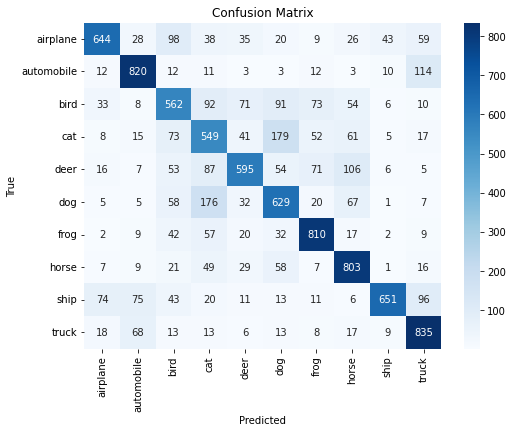

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 테스트 데이터 평가
test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# 혼동 행렬 시각화
y_pred = best_model.predict(x_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()